In [ ]:
data_train_dir = "/content/insectos_corregido"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/insectos_corregido.zip"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: insectos_corregido/8335452/d075s0348.jpg  
  inflating: insectos_corregido/8335452/d075s0349.jpg  
  inflating: insectos_corregido/8335452/d075s0350.jpg  
  inflating: insectos_corregido/8335452/d075s0351.jpg  
  inflating: insectos_corregido/8335452/d075s0352.jpg  
  inflating: insectos_corregido/8335452/d075s0364.jpg  
  inflating: insectos_corregido/8335452/d075s0365.jpg  
  inflating: insectos_corregido/8335452/d075s0366.jpg  
  inflating: insectos_corregido/8335452/d075s0367.jpg  
  inflating: insectos_corregido/8335452/d075s0368.jpg  
  inflating: insectos_corregido/8335452/d075s0369.jpg  
  inflating: insectos_corregido/8335452/d075s0370.jpg  
  inflating: insectos_corregido/8335452/d075s0383.jpg  
  inflating: insectos_corregido/8335452/d075s0384.jpg  
  inflating: insectos_corregido/8335452/d075s0385.jpg  
  inflating: insectos_corregido/8335452/d075s0386.jpg  
  inflating: insectos_corregido/8335452/d07

In [ ]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, Input, Add
from keras.layers import BatchNormalization as BN
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.metrics import TopKCategoricalAccuracy

In [ ]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [ ]:
target_size = (64, 32)
batch_size = 512
mode = 'categorical'
numclasses = 291

In [ ]:
train_generator = train_datagen.flow_from_directory(
    data_train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=mode,
    subset='training') # set as training data

Found 50776 images belonging to 291 classes.


In [ ]:
validation_generator = train_datagen.flow_from_directory(
    data_train_dir, # same directory as training data
    target_size=target_size,
    batch_size=batch_size,
    class_mode=mode,
    subset='validation') # set as validation data

Found 12543 images belonging to 291 classes.


In [ ]:
## DEF A RESNET BLOCK CONV + BN + GN + MAXPOOL
def ResNetCBGN(x,filters):

  y = Conv2D(filters = filters, kernel_size = 3, padding='same')(x) 
  y = BN()(y)
  y = Activation('relu')(y)
  y = Conv2D(filters = filters, kernel_size=  3, padding='same')(y)
  y = BN()(y)
  y = Activation('relu')(y)
  y = Conv2D(filters = filters, kernel_size=  3, padding='same')(y)
  y = BN()(y)

  x = Conv2D(filters = filters, kernel_size=  1, padding='same')(x)
  x = BN()(x)
  out = Add()([x, y])

  out= BN()(out)
  out = Activation('relu')(out)
  out = MaxPooling2D(pool_size=(2, 2))(out)
  
  return out

In [ ]:
## DEF RESNET TOPOLOGY
inputs = Input((*target_size, 3))
filters = 32
resNetModel = ResNetCBGN(inputs,filters)
filters = 64
resNetModel = ResNetCBGN(resNetModel,filters)
filters = 128
resNetModel = ResNetCBGN(resNetModel,filters)
filters = 256
resNetModel = ResNetCBGN(resNetModel,filters)
filters = 512
resNetModel = ResNetCBGN(resNetModel,filters)

resNetModel = Flatten()(resNetModel)
resNetModel = Dense(512)(resNetModel)
resNetModel = Activation('relu')(resNetModel)
resNetModel = Dense(numclasses)(resNetModel)
outputs = Activation('softmax')(resNetModel)

modelResFinal = Model(inputs, outputs)
modelResFinal.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 64, 32, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 64, 32, 32)   128         conv2d_24[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 64, 32, 32)   0           batch_normalization_29[0][0]     
______________________________________________________________________________________________

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss')

In [ ]:
checkpoint_cb = ModelCheckpoint(filepath="/content/drive/MyDrive/Colab Notebooks/insectos_mi_red_resnet/insectos_mi_red_resnet_weight", save_best_only=True, save_weights_only=True, monitor='val_accuracy')

In [ ]:
## OPTIM AND COMPILE
#opt = SGD(lr=0.1, decay=1e-6)

modelResFinal.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy', TopKCategoricalAccuracy(k=3, name="Top_3_accuracy")])

In [ ]:
## TRAINING with DA and LRA
history=modelResFinal.fit(train_generator,
                            steps_per_epoch=len(train_generator.filenames) // batch_size, 
                            epochs=50,
                            validation_data=validation_generator,
                            callbacks=[reduce_lr,checkpoint_cb],
                            verbose=1)

Epoch 1/50
99/99 [==============================] - 306s 3s/step - loss: 5.0246 - accuracy: 0.0504 - Top_3_accuracy: 0.1076 - val_loss: 12.1873 - val_accuracy: 0.0056 - val_Top_3_accuracy: 0.0246
Epoch 2/50
99/99 [==============================] - 276s 3s/step - loss: 2.9661 - accuracy: 0.2672 - Top_3_accuracy: 0.4614 - val_loss: 16.7156 - val_accuracy: 0.0093 - val_Top_3_accuracy: 0.0226
Epoch 3/50
99/99 [==============================] - 275s 3s/step - loss: 1.8632 - accuracy: 0.4819 - Top_3_accuracy: 0.7194 - val_loss: 13.5344 - val_accuracy: 0.0200 - val_Top_3_accuracy: 0.0560
Epoch 4/50
99/99 [==============================] - 274s 3s/step - loss: 1.4368 - accuracy: 0.5826 - Top_3_accuracy: 0.8065 - val_loss: 4.6948 - val_accuracy: 0.1723 - val_Top_3_accuracy: 0.3250
Epoch 5/50
99/99 [==============================] - 273s 3s/step - loss: 1.1938 - accuracy: 0.6441 - Top_3_accuracy: 0.8541 - val_loss: 3.8894 - val_accuracy: 0.2521 - val_Top_3_accuracy: 0.4405
Epoch 6/50
99/99 [====

In [ ]:
#Evaluar el mejor resultado
modelResFinal.load_weights("/content/drive/MyDrive/Colab Notebooks/insectos_mi_red_resnet/insectos_mi_red_resnet_weight")
evaluating_model = modelResFinal.evaluate_generator(validation_generator, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


25/25 [==============================] - 59s 2s/step - loss: 0.8560 - accuracy: 0.7954 - Top_3_accuracy: 0.9279


In [ ]:
import matplotlib.pyplot as plt

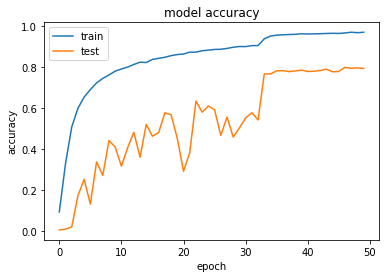

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()